In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical

In [3]:
# Load the data
# df = pd.read_csv('o-level-dataset.csv')
df = pd.read_csv('O_Level_Dataset.csv')

In [4]:
df.head(10)

,Student_ID,Academic_Year,Gender,School_Location,Residence_Location,School_Type,IsBoarding,DistanceToSchool_Km,HasElectricity,ParentStatus,...,S3_Physics,S3_Chemistry,S3_Biology,S3_Geography,S3_History,S3_Economics,S3_English,S3_Kinyarwanda,S3_ICT,A_Level_Stream
0,OLEVEL1997000001,1997,Male,Rural,Rural,Private,Yes,0.00,Yes,Both,...,100.000000,92.164435,91.234686,84.075855,83.782800,100.000000,100.000000,87.884911,96.322266,ICT
1,OLEVEL1997000002,1997,Male,Urban,Rural,Public,No,4.73,Yes,Both,...,83.540939,99.870972,94.488632,81.144719,90.764981,100.000000,99.478973,100.000000,95.904831,MCE
2,OLEVEL1997000003,1997,Male,Urban,Urban,Public,No,1.54,Yes,Both,...,82.106047,92.566897,78.802338,100.000000,89.763410,82.226902,83.123233,86.465548,86.598491,HGL
3,OLEVEL1997000004,1997,Female,Rural,Rural,Private,No,0.93,No,Both,...,81.134261,90.968684,82.638529,73.994078,70.247242,80.393502,63.673900,81.265995,62.755726,PCB
4,OLEVEL1997000005,1997,Female,Rural,Rural,Public,No,0.84,No,Both,...,57.741877,57.488407,78.136635,73.429756,97.698305,53.901652,76.291226,72.246262,65.680166,HGL
5,OLEVEL1997000006,1997,Male,Rural,Rural,Private,No,1.58,No,Both,...,88.123749,64.809035,69.207479,83.736082,83.723588,83.736206,100.000000,84.294634,88.941385,HEL
6,OLEVEL1997000007,1997,Female,Urban,Urban,Private,Yes,0.00,Yes,Both,...,77.589067,81.839618,85.096136,82.369384,91.841203,80.330567,83.477953,88.234735,100.000000,ICT
7,OLEVEL1997000008,1997,Female,Rural,Urban,Public,No,1.02,Yes,Both,...,70.302999,75.291308,80.777441,90.016303,61.777980,95.486468,56.635257,74.638284,80.039307,MEG
8,OLEVEL1997000009,1997,Male,Rural,Rural,Public,Yes,0.00,Yes,Both,...,89.571928,70.941491,87.912839,95.725858,92.860789,78.013564,70.862069,81.022411,100.000000,ICT
9,OLEVEL1997000010,1997,Male,Urban,Urban,Public,No,1.93,Yes,One,...,76.976369,74.107911,94.351300,60.379427,96.450509,77.726943,80.704558,73.926760,81.268231,PCB


In [5]:
# For classification, use S1–S3 subject scores as input features; A_Level_Stream as the target.
target_col = 'A_Level_Stream'
feature_cols = [col for col in df.columns if col.startswith(('S1_', 'S2_', 'S3_'))]


In [6]:
# Encode target labels
le_stream = LabelEncoder()
df['A_Level_Stream_Label'] = le_stream.fit_transform(df[target_col])
n_classes = df['A_Level_Stream_Label'].nunique()

In [7]:
# Normalize scores
scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [8]:
# Prepare sequence input for LSTM: (samples, timesteps, features)
def make_lstm_sequences(df, subjects):
    n_subjects = len(subjects)
    sequences = []
    for _, row in df.iterrows():
        seq = []
        for s_year in ['S1', 'S2', 'S3']:
            subj_scores = [row[f"{s_year}_{subj}"] for subj in subjects]
            seq.append(subj_scores)
        sequences.append(seq)
    return np.array(sequences)


subjects = ['Mathematics', 'Physics', 'Chemistry', 'Biology', 'Geography',
            'History', 'Economics', 'English', 'Kinyarwanda', 'ICT']

X_seq = make_lstm_sequences(df, subjects)
y = df['A_Level_Stream_Label'].values

In [9]:
# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y, test_size=0.2, stratify=y, random_state=42)

### LSTM Model (Sequence Classification)

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [11]:
# Model parameters
input_shape = (3, len(subjects))
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
# Early stopping
cb = [callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

# Training
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=cb,
    verbose=1
)

Epoch 1/30


773/773 [==============================] - 13s 11ms/step - loss: 1.7371 - accuracy: 0.3498 - val_loss: 1.0906 - val_accuracy: 0.6649
Epoch 2/30
773/773 [==============================] - 8s 10ms/step - loss: 0.9302 - accuracy: 0.6559 - val_loss: 0.6673 - val_accuracy: 0.7731
Epoch 3/30
773/773 [==============================] - 8s 11ms/step - loss: 0.7084 - accuracy: 0.7279 - val_loss: 0.4599 - val_accuracy: 0.8627
Epoch 4/30
773/773 [==============================] - 11s 15ms/step - loss: 0.6054 - accuracy: 0.7634 - val_loss: 0.4065 - val_accuracy: 0.8703
Epoch 5/30
773/773 [==============================] - 11s 14ms/step - loss: 0.5613 - accuracy: 0.7773 - val_loss: 0.3915 - val_accuracy: 0.8601
Epoch 6/30
773/773 [==============================] - 12s 16ms/step - loss: 0.5306 - accuracy: 0.7877 - val_loss: 0.3496 - val_accuracy: 0.8767
Epoch 7/30
773/773 [==============================] - 12s 15ms/step - loss: 0.5062 - accuracy: 0.7995 - val_loss: 0.3151 - val_accuracy:

In [14]:
# Evaluation
y_pred = np.argmax(model.predict(X_test), axis=1)
print("LSTM Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_stream.classes_))
print("LSTM Test Accuracy:", accuracy_score(y_test, y_pred))

483/483 [==============================] - 3s 5ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

         HEG       0.91      0.95      0.93      1527
         HEL       0.93      0.95      0.94      2149
         HGL       0.98      0.90      0.94      2361
         ICT       0.97      0.91      0.94      2539
         MCE       0.83      0.94      0.88      1317
         MEG       0.92      0.89      0.91      1476
         PCB       0.95      0.92      0.94      2238
         PCM       0.88      0.96      0.92      1837

    accuracy                           0.93     15444
   macro avg       0.92      0.93      0.92     15444
weighted avg       0.93      0.93      0.93     15444

LSTM Test Accuracy: 0.9268971768971769


###  Random Forest Baseline

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
# Flatten sequence for non-sequential models
X_rf = X_seq.reshape(X_seq.shape[0], -1)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y, test_size=0.2, stratify=y, random_state=42)

In [17]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_rf, y_train_rf)
y_pred_rf = rf.predict(X_test_rf)

In [18]:
print("Random Forest Classification Report:")
print(classification_report(y_test_rf, y_pred_rf, target_names=le_stream.classes_))
print("Random Forest Test Accuracy:", accuracy_score(y_test_rf, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

         HEG       0.89      0.85      0.87      1527
         HEL       0.85      0.88      0.86      2149
         HGL       0.84      0.89      0.87      2361
         ICT       0.85      0.88      0.87      2539
         MCE       0.89      0.81      0.85      1317
         MEG       0.90      0.78      0.84      1476
         PCB       0.87      0.88      0.87      2238
         PCM       0.88      0.90      0.89      1837

    accuracy                           0.87     15444
   macro avg       0.87      0.86      0.86     15444
weighted avg       0.87      0.87      0.87     15444

Random Forest Test Accuracy: 0.8656436156436157


##### ARIMA Example (for Score Forecast, not Stream Prediction)

###### forecast future subject scores (e.g., S3_Mathematics) using S1 and S2 (time series), use ARIMA for a single subject per student (not stream classification)

In [19]:
from statsmodels.tsa.arima.model import ARIMA

In [20]:
# Example: forecast S3_Mathematics from S1/S2 for one student
student_idx = 0
student_scores = [
    df.iloc[student_idx]['S1_Mathematics'],
    df.iloc[student_idx]['S2_Mathematics'],
    df.iloc[student_idx]['S3_Mathematics']
]

In [21]:
# Only use first two for training, last one for validation
train_scores = student_scores[:2]
test_score = student_scores[2]

In [22]:
# ARIMA fit and forecast (order (1,0,0) as an example)
model_arima = ARIMA(train_scores, order=(1, 0, 0))
model_arima_fit = model_arima.fit()
forecast = model_arima_fit.forecast()[0]
print(f"ARIMA Forecast for S3_Mathematics: {forecast:.2f}, Actual: {test_score:.2f}")

ARIMA Forecast for S3_Mathematics: 0.75, Actual: 0.94


C:\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


##### Cross-Validation (Random Forest Example)

In [23]:
from sklearn.model_selection import cross_val_score

In [24]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(rf, X_rf, y, cv=5, scoring='accuracy')
print("Random Forest CV Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

Random Forest CV Accuracy: 0.8639 (+/- 0.0026)


##### Ensemble Voting Classifier

###### You can combine LSTM and Random Forest via stacking/averaging (for real ensemble), but for now, use their predictions to compare.

In [25]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
# ==== 1. Train Random Forest ====
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_rf, y)


RandomForestClassifier(random_state=42)

In [27]:
# ==== 2. Train LSTM ====
input_shape = (3, len(subjects))
lstm_model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax')
])

In [28]:
lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = lstm_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=0
)

In [29]:
# ==== 3. Get probability predictions on test set ====
# For LSTM: (num_samples, num_classes)
lstm_probs = lstm_model.predict(X_test)

483/483 [==============================] - 2s 4ms/step


In [30]:
# For Random Forest: (need to reshape X_test for RF)
rf_probs = rf.predict_proba(X_test.reshape(X_test.shape[0], -1))

In [31]:
# ==== 4. Average the probabilities ====
ensemble_probs = (lstm_probs + rf_probs) / 2
ensemble_preds = np.argmax(ensemble_probs, axis=1)

In [32]:
# ==== 5. Evaluation ====
from sklearn.metrics import classification_report, accuracy_score
print("Ensemble (Averaging) Classification Report:")
print(classification_report(y_test, ensemble_preds, target_names=le_stream.classes_))
print("Ensemble Test Accuracy:", accuracy_score(y_test, ensemble_preds))

Ensemble (Averaging) Classification Report:
              precision    recall  f1-score   support

         HEG       1.00      1.00      1.00      1527
         HEL       1.00      1.00      1.00      2149
         HGL       1.00      1.00      1.00      2361
         ICT       1.00      1.00      1.00      2539
         MCE       0.99      1.00      0.99      1317
         MEG       1.00      1.00      1.00      1476
         PCB       1.00      1.00      1.00      2238
         PCM       0.99      1.00      1.00      1837

    accuracy                           1.00     15444
   macro avg       1.00      1.00      1.00     15444
weighted avg       1.00      1.00      1.00     15444

Ensemble Test Accuracy: 0.9968919968919969


```Explanation
Both models are trained independently.

Class probabilities from both models are averaged for each sample.

The predicted class is the one with the highest average probability.

This method, called soft voting, leverages both sequential and tabular feature learning.

###### Confusion Matrix

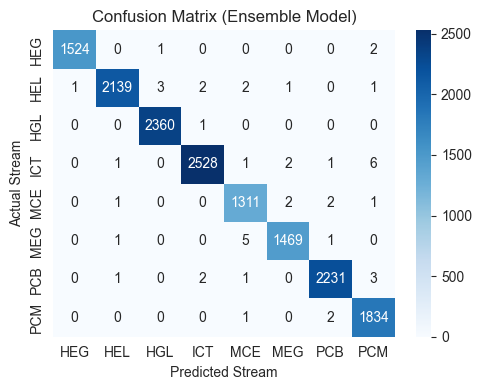

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, ensemble_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_stream.classes_,
            yticklabels=le_stream.classes_)
plt.xlabel('Predicted Stream')
plt.ylabel('Actual Stream')
plt.title('Confusion Matrix (Ensemble Model)')
plt.tight_layout()
plt.show()

###### Classification Report as Table

In [34]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, ensemble_preds, target_names=le_stream.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)


              precision    recall  f1-score       support
HEG            0.999344  0.998035  0.998689   1527.000000
HEL            0.998133  0.995347  0.996738   2149.000000
HGL            0.998308  0.999576  0.998942   2361.000000
ICT            0.998026  0.995668  0.996845   2539.000000
MCE            0.992430  0.995444  0.993935   1317.000000
MEG            0.996608  0.995257  0.995932   1476.000000
PCB            0.997318  0.996872  0.997095   2238.000000
PCM            0.992962  0.998367  0.995657   1837.000000
accuracy       0.996892  0.996892  0.996892      0.996892
macro avg      0.996641  0.996821  0.996729  15444.000000
weighted avg   0.996897  0.996892  0.996893  15444.000000


###### Bar Plot of Per-Class Accuracy(See which streams are predicted best or worst.)

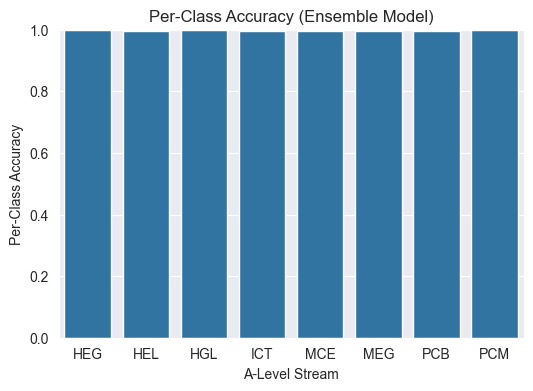

In [35]:
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(6, 4))
sns.barplot(x=le_stream.classes_, y=per_class_accuracy)
plt.ylabel('Per-Class Accuracy')
plt.xlabel('A-Level Stream')
plt.ylim(0, 1)
plt.title('Per-Class Accuracy (Ensemble Model)')
plt.show()


###### Probability Distribution for a Single Sample (Visualize how confident the ensemble is about a particular student's prediction.)

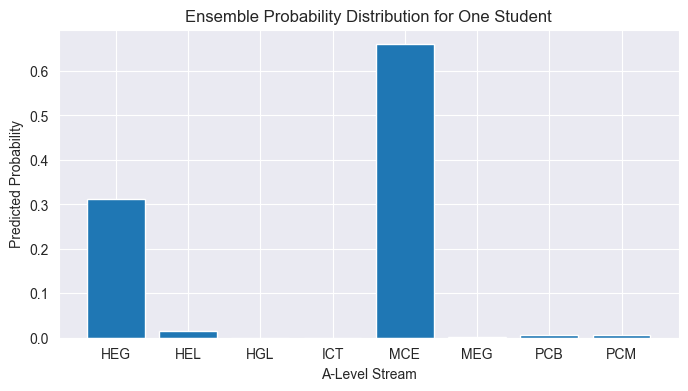

In [36]:
sample_idx = 2  # pick an index from your test set
plt.figure(figsize=(8, 4))
plt.bar(le_stream.classes_, ensemble_probs[sample_idx])
plt.title('Ensemble Probability Distribution for One Student')
plt.ylabel('Predicted Probability')
plt.xlabel('A-Level Stream')
plt.show()


In [37]:
import joblib

# Save LSTM (Keras)
lstm_model.save('lstm_stream_model.h5')

# Save Random Forest
joblib.dump(rf, 'rf_stream_model.pkl')

# Save scaler and encoders (very important for consistent preprocessing!)
joblib.dump(scaler, 'score_scaler.pkl')
joblib.dump(le_stream, 'stream_label_encoder.pkl')

C:\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['stream_label_encoder.pkl']

In [38]:
lstm_loaded = tf.keras.models.load_model("lstm_stream_model.h5")
rf_loaded = joblib.load("rf_stream_model.pkl")
le_stream_loaded = joblib.load("stream_label_encoder.pkl")
scaler_loaded = joblib.load("score_scaler.pkl")


In [39]:
new_student = {
    'S1_Mathematics': 77, 'S1_Physics': 75, 'S1_Chemistry': 92, 'S1_Biology': 31, 'S1_Geography': 86,
    'S1_History': 65, 'S1_Economics': 60, 'S1_English': 75, 'S1_Kinyarwanda': 80, 'S1_ICT': 85,
    'S2_Mathematics': 70, 'S2_Physics': 88, 'S2_Chemistry': 95, 'S2_Biology': 24, 'S2_Geography': 88,
    'S2_History': 67, 'S2_Economics': 62, 'S2_English': 78, 'S2_Kinyarwanda': 81, 'S2_ICT': 86,
    'S3_Mathematics': 75, 'S3_Physics': 82, 'S3_Chemistry': 98, 'S3_Biology': 47, 'S3_Geography': 87,
    'S3_History': 69, 'S3_Economics': 65, 'S3_English': 80, 'S3_Kinyarwanda': 83, 'S3_ICT': 88,
}
df_new = pd.DataFrame([new_student])

In [40]:
# --- Normalize features (must match train order) ---
subject_cols = [col for col in df_new.columns if col.startswith(('S1_', 'S2_', 'S3_'))]
df_new[subject_cols] = scaler_loaded.transform(df_new[subject_cols])

In [41]:
# --- Normalize features (must match train order) ---
subject_cols = [col for col in df_new.columns if col.startswith(('S1_', 'S2_', 'S3_'))]
df_new[subject_cols] = scaler_loaded.transform(df_new[subject_cols])

In [42]:
# --- Prepare LSTM input (samples, timesteps, features) ---
subjects = ['Mathematics', 'Physics', 'Chemistry', 'Biology', 'Geography',
            'History', 'Economics', 'English', 'Kinyarwanda', 'ICT']

In [43]:
def make_lstm_sequences_from_df(df, subjects):
    n_subjects = len(subjects)
    sequences = []
    for _, row in df.iterrows():
        seq = []
        for s_year in ['S1', 'S2', 'S3']:
            subj_scores = [row[f"{s_year}_{subj}"] for subj in subjects]
            seq.append(subj_scores)
        sequences.append(seq)
    return np.array(sequences)
X_lstm_new = make_lstm_sequences_from_df(df_new, subjects)
X_rf_new = X_lstm_new.reshape(X_lstm_new.shape[0], -1)

In [44]:
# --- Get probabilities from both models ---
lstm_probs = lstm_loaded.predict(X_lstm_new)
rf_probs = rf_loaded.predict_proba(X_rf_new)

1/1 [==============================] - 1s 770ms/step


In [45]:
# --- Soft-voting ensemble (50-50) ---
ensemble_probs = (lstm_probs + rf_probs) / 2
ensemble_pred = np.argmax(ensemble_probs, axis=1)

In [46]:
# --- Decode the predicted stream label ---
stream_label = le_stream_loaded.inverse_transform(ensemble_pred)[0]
print("Predicted A-Level Stream:", stream_label)

Predicted A-Level Stream: HGL
